In [643]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Filtering functions

Here are four filters included : 
- Lowpass
- Highpass
- Bandpass
- Peak filter (for glitches)

The following template was used to integrate the filters easily in the data processing pipeline:

```python
def clean_B(data, params):

    # Do stuff with data, with parameters in the dict param

    return data

```

All these filters can be integrated in the Web application.

In [644]:
# Util function

def calc_sampling_freq(df):
    """ Compute the sampling frequency of a dataframe """
    t_s = df["velocity"].index.diff().median().total_seconds()

    return 1/t_s

In [645]:
from scipy.signal import butter, lfilter, filtfilt

def bandpass_filter(dataframe, **kwargs):
    """ Bandpass filter applied on all velocities okf a dataframe """
    
    fs = calc_sampling_freq(dataframe)

    b, a = butter(kwargs["order"], [kwargs["f_lo"], kwargs["f_hi"]], fs=fs, btype='band')

    data_out = dataframe.copy()
    data_out["velocity"] = lfilter(b, a, dataframe["velocity"])

    return data_out

In [646]:
from scipy.signal import find_peaks

def peak_filter(dataframe, **kwargs):
    """ This filter is used to remove glitches from the data"""

    freq = calc_sampling_freq(dataframe)
    
    dataframe_max = max(dataframe["velocity"])
    dataframe_min = min(dataframe["velocity"])

    abs_max = max(dataframe_max, abs(dataframe_min))

    wlen = kwargs["prominence_valley_time"] * freq # prominence_valley_time [s] * freq [samples/sec]

    peaks, props = find_peaks(abs(dataframe["velocity"]),
                            width=[kwargs["width_time_min"]*freq, kwargs["width_time_max"]*freq],
                            distance=kwargs["distance_time"]*freq,
                            prominence=kwargs["prominence_percent"]/100*abs_max,
                            wlen=wlen)
    
    data_out = dataframe.copy()

    # Detected peaks are replaced by zeros
    # Further processing will process these zeros as missing data
    for peak in peaks:
        data_out.iloc[peak-200:peak+200] = 0

    return data_out

In [647]:
from obspy.signal.filter import lowpass

def lowpass_filter(dataframe, **kwargs):
    """ Lowpass filter for all velocities of a dataframe """
    data_out = dataframe.copy()

    freq = calc_sampling_freq(dataframe)

    data_out["velocity"] = lowpass(dataframe["velocity"], kwargs["frequency"], freq, kwargs["filter_order"], kwargs["zerophase"])

    return data_out


In [648]:
from obspy.signal.filter import  highpass

def highpass_filter(dataframe, **kwargs):
    """ Highpass filter for all velocities of a dataframe """
    data_out = dataframe.copy()

    freq = calc_sampling_freq(dataframe)

    data_out["velocity"] = highpass(data_out, kwargs["frequency"], freq, kwargs["filter_order"], kwargs["zerophase"])

    return data_out


## Detection algorithms
One detection algorithm was developed and is presented in this section. It is a detection algorithm based on the peaks.

The energy of the signal is used (x(t) = abs(y(t))^2) to amplify the peaks. 

**It is important to remove the glitches from the signal as they will stand out when the energy of the signal is used.**

In [649]:
from scipy.signal import find_peaks

def peak_detection(dataframe, **kwargs):

    freq = calc_sampling_freq(dataframe)

    abs_data_power = dataframe.copy()
    abs_data_power["velocity"] = abs(dataframe["velocity"])**2

    abs_max = abs_data_power["velocity"].max()

    threshold = kwargs["peak_detection_threshold"]  * abs_max

    peaks, props = find_peaks(abs_data_power["velocity"], prominence=threshold)

    first_peak = 0
    last_peak_range = 0
    last_peak = 0
    max_peak_length = 5000 * freq    # Arbitrary value
    start_peaks = []

    # Extract only start of detected seismic activity
    for peak in peaks:
        if first_peak == 0:
            start_peaks.append(peak)
            last_peak = peak
            first_peak = 1
        else:
            last_peak_range = peak - last_peak
            
            if last_peak_range >= max_peak_length:
                start_peaks.append(peak)
                last_peak = peak
            else:
                continue

    return start_peaks


## Example

One example of the glitches removal and peak detection is presented in the following section.

First, the glitches are removed from the signal. Then, the peak detection algorithm is applied and the seismic activity is detected.

The parameters used were tune and should work with multiple datasets. For the glitch removal, the user shall tune the parameters with the live view.

This simple pipeline was used for multiple datasets. Cases with a signal that does not have any peaks that stand out can be problematic.

In [650]:
# Load the data
file = "../out/lunar/xa.s12.00.mhz.1972-05-11HR00_evid00055.parquet"
data = pd.read_parquet(file)

In [651]:
# Parameters for the glitches removal
kwargs = {"prominence_percent":60, "prominence_valley_time":15, "distance_time":1, "width_time_min":0, "width_time_max": 15}

# Remove the glitches
data_f = peak_filter(data, **kwargs)

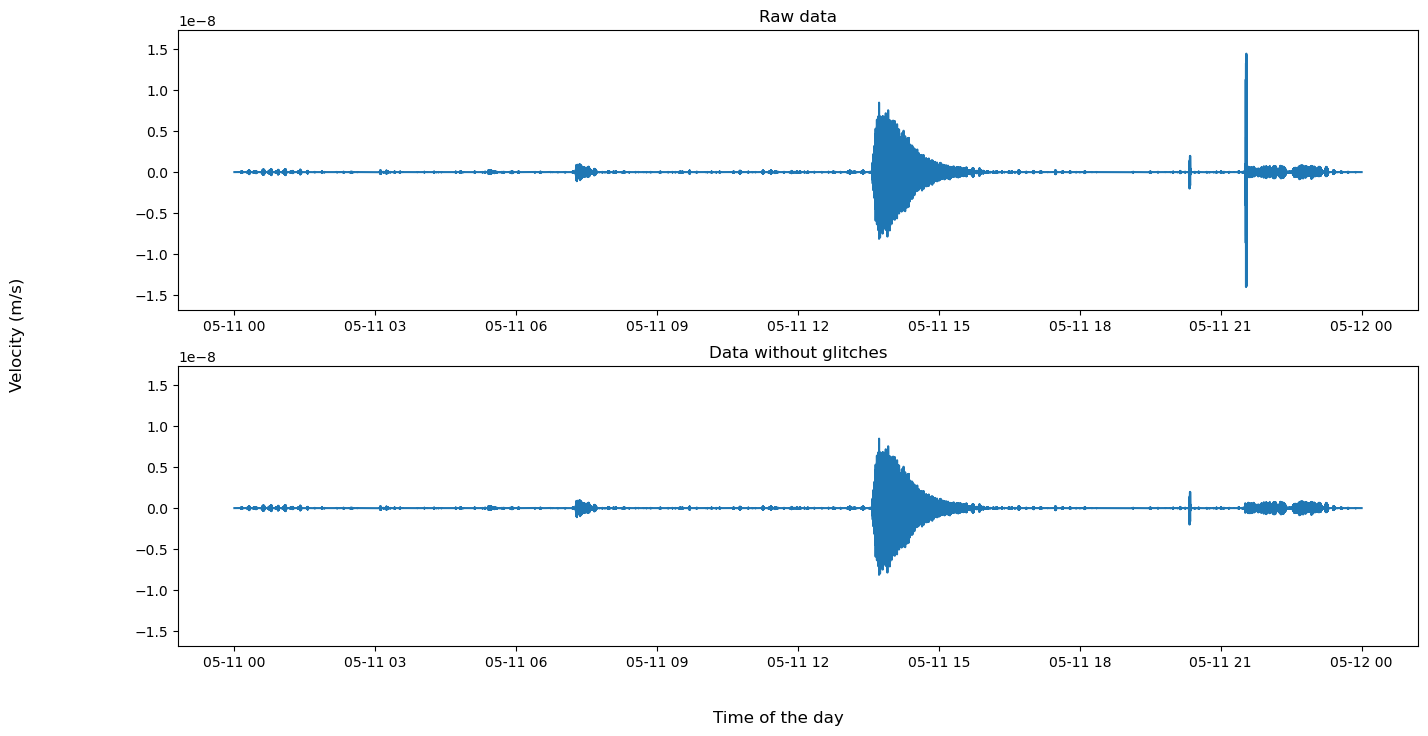

In [656]:
fig= plt.figure(figsize=(16, 8))

fig.supxlabel("Time of the day")
fig.supylabel("Velocity (m/s)")

min_value = min(data.velocity)
max_value = max(data.velocity)

ax = plt.subplot(2, 1, 1)
ax.title.set_text("Raw data")
ax.plot(data.velocity)
ax.set_ylim([min_value*1.2, max(data.velocity)*1.2])

ax2 = plt.subplot(2, 1, 2)
ax2.title.set_text("Data without glitches")
ax2.plot(data_f.velocity)
ax2.set_ylim([min_value*1.2, max(data.velocity)*1.2])

plt.show()

In [653]:
# Peak detection parameters
kwargs_detection = {"peak_detection_threshold":0.1} 

peaks = peak_detection(data_f, **kwargs_detection)

In [654]:
# Get peak index associated timestamps
peaks_timestamp = data.iloc[peaks].index


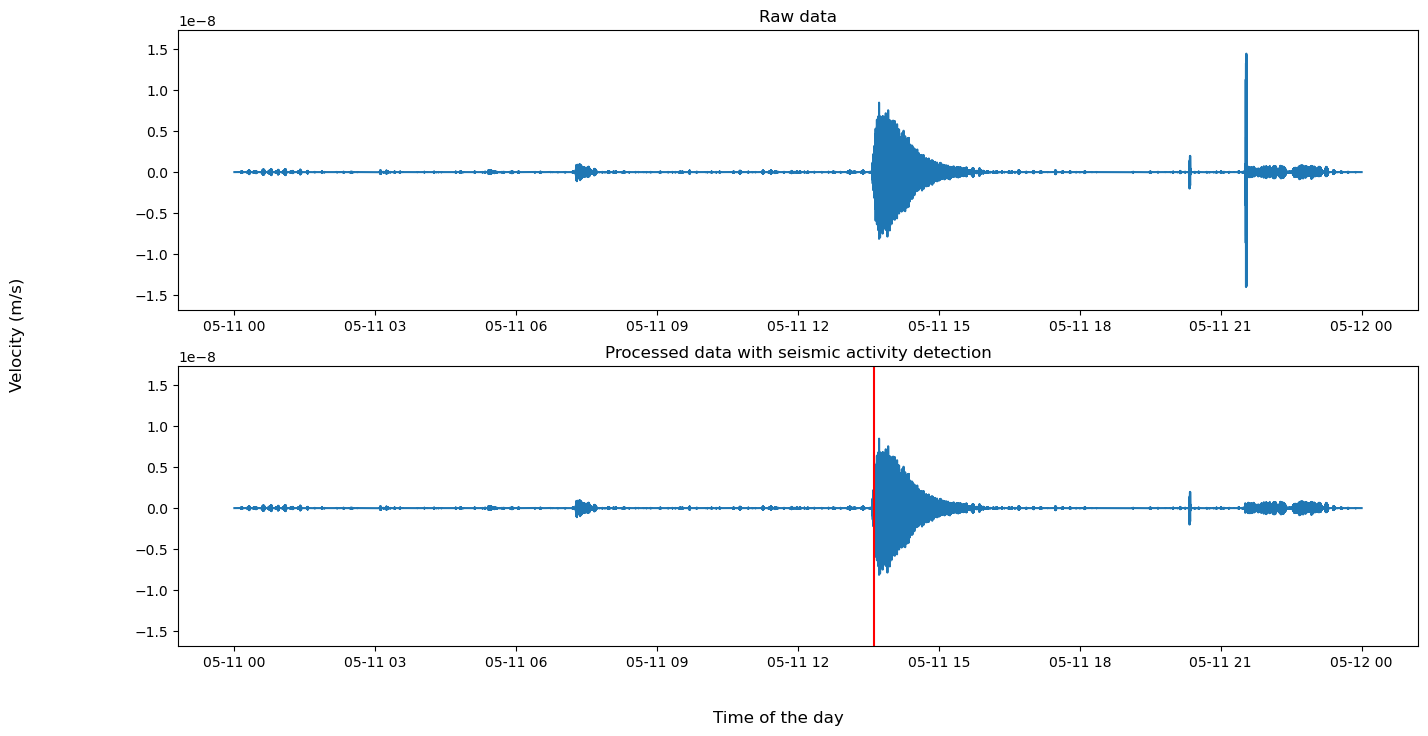

In [657]:
# Plot the raw data and the filtered data used for detection

fig= plt.figure(figsize=(16, 8))

fig.supxlabel("Time of the day")
fig.supylabel("Velocity (m/s)")

min_value = min(data.velocity)
max_value = max(data.velocity)

ax = plt.subplot(2, 1, 1)
ax.title.set_text("Raw data")
ax.plot(data.velocity)
ax.set_ylim([min_value*1.2, max(data.velocity)*1.2])

ax2 = plt.subplot(2, 1, 2)
ax2.title.set_text("Processed data with seismic activity detection")
ax2.plot(data_f.velocity)
ax2.set_ylim([min_value*1.2, max(data.velocity)*1.2])
for peak in peaks_timestamp:
    ax2.axvline(peak, color='r')

